In [2]:
import numpy as np
import copy
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
%matplotlib inline

/Users/zed/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Problem 2
## (a)

In [3]:
pfs = pd.read_csv('25_Portfolios_5x5.CSV', index_col=0)
facs = pd.read_csv('F-F_Research_Data_Factors.CSV', index_col=0)
pfs = pfs.loc[196801:]
facs = facs.loc[196801:]
n = len(pfs)
pfs.columns

Index(['SMALL LoBM', 'ME1 BM2', 'ME1 BM3', 'ME1 BM4', 'SMALL HiBM', 'ME2 BM1',
       'ME2 BM2', 'ME2 BM3', 'ME2 BM4', 'ME2 BM5', 'ME3 BM1', 'ME3 BM2',
       'ME3 BM3', 'ME3 BM4', 'ME3 BM5', 'ME4 BM1', 'ME4 BM2', 'ME4 BM3',
       'ME4 BM4', 'ME4 BM5', 'BIG LoBM', 'ME5 BM2', 'ME5 BM3', 'ME5 BM4',
       'BIG HiBM'],
      dtype='object')

In [72]:
pfs_excess = pfs.values - facs.RF.values.reshape((n,1))
pfs_mean = pd.DataFrame(
    pfs_excess.mean(axis=0).reshape(5, 5), 
    columns=['BM1', 'BM2', 'BM3', 'BM4', 'BM5'],
    index=['ME1', 'ME2', 'ME3', 'ME4', 'ME5']
)
pfs_se = pd.DataFrame(
    (pfs_excess.std(axis=0) / np.sqrt(n)).reshape(5,5),
    columns=['BM1', 'BM2', 'BM3', 'BM4', 'BM5'],
    index=['ME1', 'ME2', 'ME3', 'ME4', 'ME5']
)
t_stat = pfs_mean/pfs_se
rets = pd.concat([pfs_mean, pfs_se, t_stat], axis=0).sort_index()
rets.index = pd.MultiIndex.from_product(
    (pfs_mean.index.unique(), ['mean', 'se', 't-stat'])
)
rets

BM1       BM2       BM3       BM4       BM5
ME1 mean    0.138941  0.721294  0.725931  0.938094  1.013257
    se      0.322117  0.280844  0.242438  0.229816  0.243004
    t-stat  0.431337  2.568314  2.994295  4.081942  4.169705
ME2 mean    0.451483  0.732897  0.801649  0.875069  0.916870
    se      0.293281  0.244021  0.220284  0.211684  0.244061
    t-stat  1.539423  3.003419  3.639155  4.133851  3.756730
ME3 mean    0.481265  0.765048  0.701462  0.823439  0.993619
    se      0.269862  0.221977  0.203838  0.198656  0.229668
    t-stat  1.783373  3.446511  3.441274  4.145044  4.326334
ME4 mean    0.614499  0.622239  0.681545  0.794719  0.791070
    se      0.242311  0.210575  0.202576  0.193848  0.230790
    t-stat  2.535990  2.954949  3.364389  4.099694  3.427656
ME5 mean    0.501318  0.573863  0.571117  0.473859  0.679433
    se      0.189887  0.181751  0.175723  0.189212  0.219410
    t-stat  2.640088  3.157413  3.250092  2.504379  3.096636

## (b)

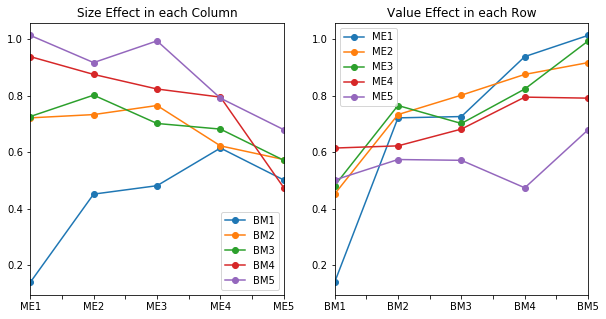

In [17]:
fig, axes = plt.subplots(1,2,figsize=(10,5))
pfs_mean.plot(ax=axes[0], style='-o')
pfs_mean.T.plot(ax=axes[1], style='-o')
axes[0].set_title('Size Effect in each Column')
_ = axes[1].set_title('Value Effect in each Row')

- For the same BM quantile group (above BM2), we can observe a size effect across different size groups, in the sense that the excess return increases as size group goes from BIG to SMALL. (Figure 1)
- The size effect described above is not evident for LoBM(BM1) group: the excess returns do not increase monotonically.
- For the same size quantile group, we can observe a value effect across different BM groups, in the sense that the excess return increases as BM group goes from LowBM to HighBM. (Figure 2)
- The value effect is stronger in the SMALL(ME1) size group, as the blue line in figure 2 has the steepest slope.

## (c)

In [69]:
X = sm.add_constant(facs['Mkt-RF'].values)
capm_alphas, capm_tstats, capm_pvalues = [], [], []
for i, p in enumerate(pfs.columns):
    y = pfs_excess[:, i]
    res = sm.OLS(y, X).fit()
    capm_alphas.append(res.params[0])
    capm_tstats.append(res.tvalues[0])
    capm_pvalues.append(res.pvalues[0])
tables = []
for xx in [capm_alphas, capm_tstats, capm_pvalues]:
    tab =  pd.DataFrame(
        np.array(xx).reshape(5,5),
        columns=['BM1', 'BM2', 'BM3', 'BM4', 'BM5'],
        index=['ME1', 'ME2', 'ME3', 'ME4', 'ME5']
    )
    tables.append(tab)
signif = pd.DataFrame([np.nan]*25).reindex_like(tables[2])
signif[:] = '  '
signif[tables[2] < 0.05] = '(*)'
capm = pd.concat([tables[0], tables[1], signif], axis=0).sort_index()
capm.index = pd.MultiIndex.from_product(
    (capm.index.unique(), ['alpha', 't-stat', 'p<0.05'])
)
capm

BM1        BM2       BM3        BM4       BM5
ME1 alpha   -0.604325  0.0792367  0.151235   0.410014  0.462256
    t-stat   -3.08398   0.456519     1.079    2.91167   3.03706
    p<0.05        (*)                             (*)       (*)
ME2 alpha    -0.28214   0.117712  0.252293   0.352649  0.336371
    t-stat    -1.8987   0.975059   2.24046     3.1656   2.40059
    p<0.05                             (*)        (*)       (*)
ME3 alpha   -0.214433   0.180408   0.17511   0.326279  0.443554
    t-stat   -1.73615    1.94766   1.88901    3.24615   3.41398
    p<0.05                                        (*)       (*)
ME4 alpha   -0.033038  0.0555156  0.153521   0.299895  0.225168
    t-stat  -0.352906    0.71254   1.73193    3.25954   1.82287
    p<0.05                                        (*)          
ME5 alpha  -0.0130529  0.0802354  0.124674  0.0141237  0.179359
    t-stat  -0.194115    1.27065   1.47073   0.136355   1.31604
    p<0.05

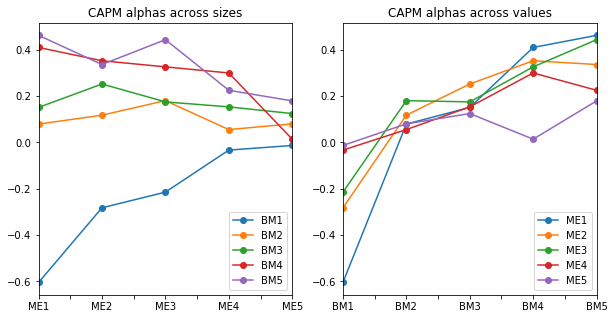

In [60]:
fig, axes = plt.subplots(1,2,figsize=(10,5))
tables[0].plot(ax=axes[0], style='-o')
tables[0].T.plot(ax=axes[1], style='-o')
axes[0].set_title('CAPM alphas across sizes')
_ = axes[1].set_title('CAPM alphas across values')

## (d)

In [68]:
X = sm.add_constant(facs[['Mkt-RF', 'SMB', 'HML']].values)
ff3_alphas, ff3_tstats, ff3_pvalues = [], [], []
for i, p in enumerate(pfs.columns):
    y = pfs_excess[:, i]
    res = sm.OLS(y, X).fit()
    ff3_alphas.append(res.params[0])
    ff3_tstats.append(res.tvalues[0])
    ff3_pvalues.append(res.pvalues[0])
tables = []
for xx in [ff3_alphas, ff3_tstats, ff3_pvalues]:
    tab =  pd.DataFrame(
        np.array(xx).reshape(5,5),
        columns=['BM1', 'BM2', 'BM3', 'BM4', 'BM5'],
        index=['ME1', 'ME2', 'ME3', 'ME4', 'ME5']
    )
    tables.append(tab)
signif = pd.DataFrame([np.nan]*25).reindex_like(tables[2])
signif[:] = '  '
signif[tables[2] < 0.05] = '(*)'
ff3 = pd.concat([tables[0], tables[1], signif], axis=0).sort_index()
ff3.index = pd.MultiIndex.from_product(
    (ff3.index.unique(), ['alpha', 't-stat', 'p<0.05'])
)
ff3

BM1         BM2         BM3        BM4        BM5
ME1 alpha   -0.547419 -0.00188453  -0.0285962   0.169426   0.121075
    t-stat   -5.62311  -0.0260974   -0.523543    3.10497    2.11213
    p<0.05        (*)                                (*)        (*)
ME2 alpha   -0.167721   0.0232988   0.0469446  0.0768339 -0.0407018
    t-stat   -2.46079    0.395727    0.793127    1.48421  -0.733885
    p<0.05        (*)                                              
ME3 alpha  -0.0678117   0.0795249  -0.0269168  0.0524966   0.079584
    t-stat   -1.09019     1.19467   -0.405653   0.817183      1.015
    p<0.05                                                         
ME4 alpha     0.11902  -0.0376912  -0.0348759  0.0584575  -0.119813
    t-stat    1.91318   -0.521096   -0.468031   0.859294   -1.39163
    p<0.05                                                         
ME5 alpha    0.162147   0.0504822  0.00859773  -0.248215  -0.157442
    t-stat    3.50773    0.881661    0.123204   -3.80089   -1.57558
    p<0.05        (*)                                (*)

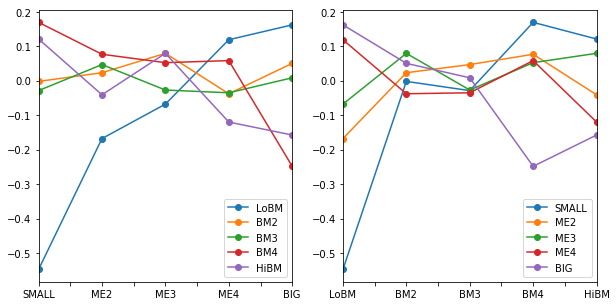

In [110]:
fig, axes = plt.subplots(1,2,figsize=(10,5))
ff3_alphas.plot(ax=axes[0], style='-o')
ff3_alphas.T.plot(ax=axes[1], style='-o')

## (e)

                 BM1       BM2       BM3       BM4       BM5
ME1 mean    0.279520  0.911910  0.851436  1.074964  1.078133
    se      0.397315  0.346695  0.281501  0.270598  0.282844
    t-stat  0.703521  2.630298  3.024629  3.972553  3.811763
ME2 mean    0.673830  0.906238  0.946844  0.917159  0.928510
    se      0.350828  0.284240  0.255377  0.254190  0.302355
    t-stat  1.920685  3.188284  3.707637  3.608169  3.070930
ME3 mean    0.687848  0.906062  0.834394  0.920435  1.059032
    se      0.323769  0.259975  0.240980  0.243974  0.278055
    t-stat  2.124506  3.485189  3.462497  3.772677  3.808714
ME4 mean    0.880749  0.878720  0.767234  0.923185  0.851772
    se      0.291348  0.238622  0.247059  0.232234  0.283599
    t-stat  3.023010  3.682481  3.105468  3.975237  3.003433
ME5 mean    0.772807  0.751408  0.772299  0.505007  0.801949
    se      0.221474  0.210062  0.208792  0.244736  0.295633
    t-stat  3.489385  3.577085  3.698892  2.063480  2.712648
                  BM1   

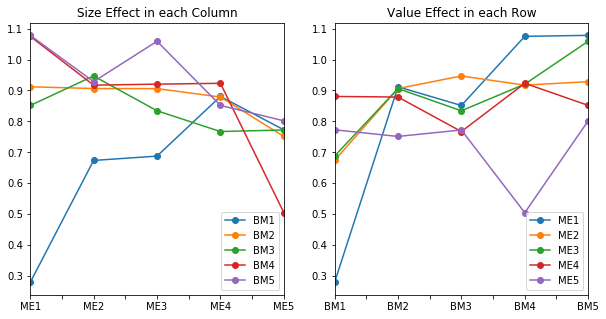

In [75]:
pfs = pd.read_csv('25_Portfolios_5x5.CSV', index_col=0)
facs = pd.read_csv('F-F_Research_Data_Factors.CSV', index_col=0)
pfs = pfs.loc[198801:]
facs = facs.loc[198801:]
n = len(pfs)

# repeat (a)
pfs_excess = pfs.values - facs.RF.values.reshape((n,1))
pfs_mean = pd.DataFrame(
    pfs_excess.mean(axis=0).reshape(5, 5), 
    columns=['BM1', 'BM2', 'BM3', 'BM4', 'BM5'],
    index=['ME1', 'ME2', 'ME3', 'ME4', 'ME5']
)
pfs_se = pd.DataFrame(
    (pfs_excess.std(axis=0) / np.sqrt(n)).reshape(5,5),
    columns=['BM1', 'BM2', 'BM3', 'BM4', 'BM5'],
    index=['ME1', 'ME2', 'ME3', 'ME4', 'ME5']
)
t_stat = pfs_mean/pfs_se
rets = pd.concat([pfs_mean, pfs_se, t_stat], axis=0).sort_index()
rets.index = pd.MultiIndex.from_product(
    (pfs_mean.index.unique(), ['mean', 'se', 't-stat'])
)
print(rets)

# repeat (b)
fig, axes = plt.subplots(1,2,figsize=(10,5))
pfs_mean.plot(ax=axes[0], style='-o')
pfs_mean.T.plot(ax=axes[1], style='-o')
axes[0].set_title('Size Effect in each Column')
_ = axes[1].set_title('Value Effect in each Row')

# repeat (c)
X = sm.add_constant(facs['Mkt-RF'].values)
capm_alphas, capm_tstats, capm_pvalues = [], [], []
for i, p in enumerate(pfs.columns):
    y = pfs_excess[:, i]
    res = sm.OLS(y, X).fit()
    capm_alphas.append(res.params[0])
    capm_tstats.append(res.tvalues[0])
    capm_pvalues.append(res.pvalues[0])
tables = []
for xx in [capm_alphas, capm_tstats, capm_pvalues]:
    tab =  pd.DataFrame(
        np.array(xx).reshape(5,5),
        columns=['BM1', 'BM2', 'BM3', 'BM4', 'BM5'],
        index=['ME1', 'ME2', 'ME3', 'ME4', 'ME5']
    )
    tables.append(tab)
signif = pd.DataFrame([np.nan]*25).reindex_like(tables[2])
signif[:] = '  '
signif[tables[2] < 0.05] = '(*)'
capm = pd.concat([tables[0], tables[1], signif], axis=0).sort_index()
capm.index = pd.MultiIndex.from_product(
    (capm.index.unique(), ['alpha', 't-stat', 'p<0.05'])
)
print(capm)

# repeat (d)
X = sm.add_constant(facs[['Mkt-RF', 'SMB', 'HML']].values)
ff3_alphas, ff3_tstats, ff3_pvalues = [], [], []
for i, p in enumerate(pfs.columns):
    y = pfs_excess[:, i]
    res = sm.OLS(y, X).fit()
    ff3_alphas.append(res.params[0])
    ff3_tstats.append(res.tvalues[0])
    ff3_pvalues.append(res.pvalues[0])
tables = []
for xx in [ff3_alphas, ff3_tstats, ff3_pvalues]:
    tab =  pd.DataFrame(
        np.array(xx).reshape(5,5),
        columns=['BM1', 'BM2', 'BM3', 'BM4', 'BM5'],
        index=['ME1', 'ME2', 'ME3', 'ME4', 'ME5']
    )
    tables.append(tab)
signif = pd.DataFrame([np.nan]*25).reindex_like(tables[2])
signif[:] = '  '
signif[tables[2] < 0.05] = '(*)'
ff3 = pd.concat([tables[0], tables[1], signif], axis=0).sort_index()
ff3.index = pd.MultiIndex.from_product(
    (ff3.index.unique(), ['alpha', 't-stat', 'p<0.05'])
)
print(ff3)

# Problem 3
## (a)

In [133]:
pfs = pd.read_csv('25_Portfolios_5x5.CSV', index_col=0)
def cum_returns(rets, w):
    rets_p = rets.dot(w)
    return np.cumprod(1+rets_p)
def sharpe(timeslice, w):
    pf_r = (pfs.loc[timeslice].values).dot(w)/100
    excess_r = pf_r - facs.loc[timeslice, 'RF'].values/100
    return np.sqrt(12)*excess_r.mean()/pf_r.std()

Sharpe ratio (1991/01 - 2018/10): 0.6705
Sharpe ratio (1991/01 - 2005/12): 0.7862
Sharpe ratio (2006/01 - 2018/10): 0.5523


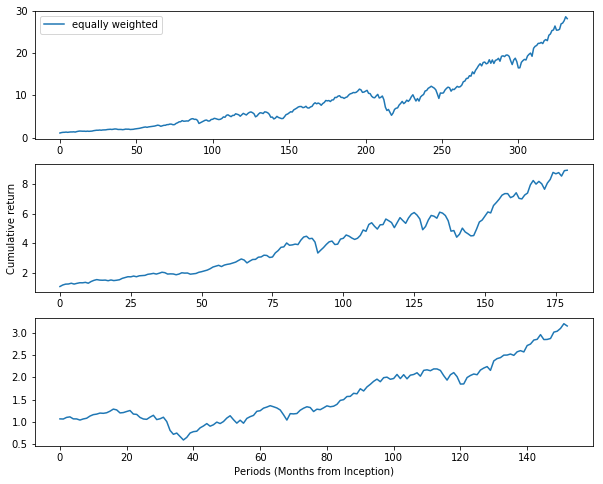

In [134]:
fig, axes = plt.subplots(3,1,figsize=(10,8))
equal_w = np.ones((25,1))/25
axes[0].plot( cum_returns(pfs.loc[199101:].values/100, equal_w), label='equally weighted')
axes[1].plot( cum_returns(pfs.loc[199101:200512].values/100, equal_w), label='strategy')
axes[2].plot( cum_returns(pfs.loc[200601:201810].values/100, equal_w), label='strategy')
axes[0].legend()
axes[1].set_ylabel('Cumulative return')
axes[2].set_xlabel('Periods (Months from Inception)')

print(f'Sharpe ratio (1991/01 - 2018/10): {sharpe(slice(199101, 201810), equal_w):.4f}')
print(f'Sharpe ratio (1991/01 - 2005/12): {sharpe(slice(199101, 200512), equal_w):.4f}')
print(f'Sharpe ratio (2006/01 - 2018/10): {sharpe(slice(200601, 201810), equal_w):.4f}')

## (b)

Sharpe ratio (1991/01 - 2018/10): 0.6916
Sharpe ratio (1991/01 - 2005/12): 0.9773
Sharpe ratio (2006/01 - 2018/10): 0.4414


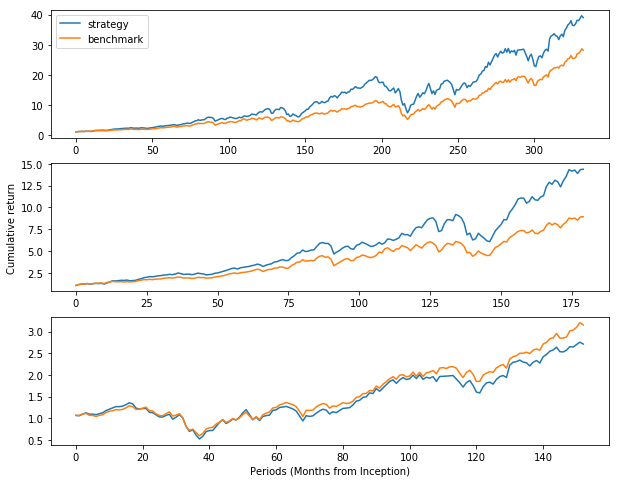

In [135]:
fig, axes = plt.subplots(3,1,figsize=(10,8))
w1 = np.array([0,0,0,0,0.2]*5).reshape((25,1))
axes[0].plot( cum_returns(pfs.loc[199101:].values/100, w1), label='strategy')
axes[1].plot( cum_returns(pfs.loc[199101:200512].values/100, w1),  label='strategy')
axes[2].plot( cum_returns(pfs.loc[200601:201810].values/100, w1), label='strategy')

axes[0].plot( cum_returns(pfs.loc[199101:].values/100, equal_w),  label='benchmark')
axes[1].plot( cum_returns(pfs.loc[199101:200512].values/100, equal_w),label='benchmark' )
axes[2].plot( cum_returns(pfs.loc[200601:201810].values/100, equal_w), label='benchmark' )
axes[0].legend()
axes[1].set_ylabel('Cumulative return')
axes[2].set_xlabel('Periods (Months from Inception)')

print(f'Sharpe ratio (1991/01 - 2018/10): {sharpe(slice(199101, 201810), w1):.4f}')
print(f'Sharpe ratio (1991/01 - 2005/12): {sharpe(slice(199101, 200512), w1):.4f}')
print(f'Sharpe ratio (2006/01 - 2018/10): {sharpe(slice(200601, 201810), w1):.4f}')

## (c)

Sharpe ratio (1991/01 - 2018/10): 0.7013
Sharpe ratio (1991/01 - 2005/12): 1.0266
Sharpe ratio (2006/01 - 2018/10): 0.4248


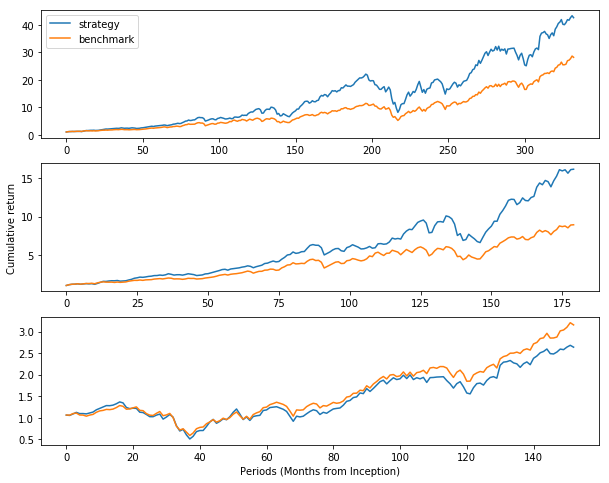

In [136]:
fig, axes = plt.subplots(3,1,figsize=(10,8))
w1 = np.array([-0.1/5,0,0,0,1.1/5]*5).reshape((25,1))
axes[0].plot( cum_returns(pfs.loc[199101:].values/100, w1), label='strategy')
axes[1].plot( cum_returns(pfs.loc[199101:200512].values/100, w1),  label='strategy')
axes[2].plot( cum_returns(pfs.loc[200601:201810].values/100, w1), label='strategy')

axes[0].plot( cum_returns(pfs.loc[199101:].values/100, equal_w),  label='benchmark')
axes[1].plot( cum_returns(pfs.loc[199101:200512].values/100, equal_w),label='benchmark' )
axes[2].plot( cum_returns(pfs.loc[200601:201810].values/100, equal_w), label='benchmark' )
axes[0].legend()
axes[1].set_ylabel('Cumulative return')
axes[2].set_xlabel('Periods (Months from Inception)')

print(f'Sharpe ratio (1991/01 - 2018/10): {sharpe(slice(199101, 201810), w1):.4f}')
print(f'Sharpe ratio (1991/01 - 2005/12): {sharpe(slice(199101, 200512), w1):.4f}')
print(f'Sharpe ratio (2006/01 - 2018/10): {sharpe(slice(200601, 201810), w1):.4f}')

## (d)

Sharpe ratio (1991/01 - 2018/10): 0.7074
Sharpe ratio (1991/01 - 2005/12): 1.0659
Sharpe ratio (2006/01 - 2018/10): 0.4083


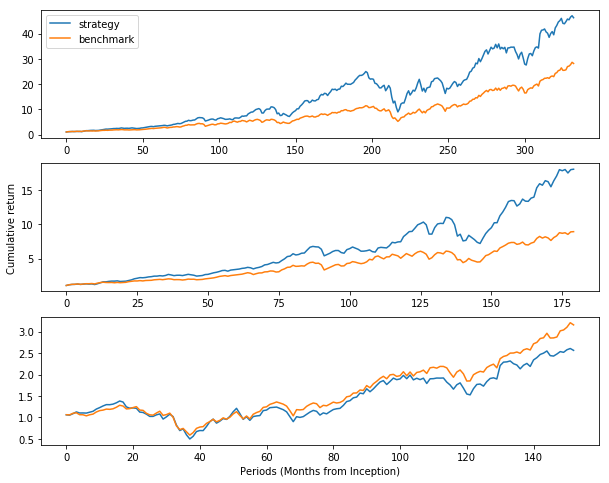

In [137]:
fig, axes = plt.subplots(3,1,figsize=(10,8))
w1 = np.array([-0.2/5,0,0,0,1.2/5]*5).reshape((25,1))
axes[0].plot( cum_returns(pfs.loc[199101:].values/100, w1), label='strategy')
axes[1].plot( cum_returns(pfs.loc[199101:200512].values/100, w1),  label='strategy')
axes[2].plot( cum_returns(pfs.loc[200601:201810].values/100, w1), label='strategy')

axes[0].plot( cum_returns(pfs.loc[199101:].values/100, equal_w),  label='benchmark')
axes[1].plot( cum_returns(pfs.loc[199101:200512].values/100, equal_w),label='benchmark' )
axes[2].plot( cum_returns(pfs.loc[200601:201810].values/100, equal_w), label='benchmark' )
axes[0].legend()
axes[1].set_ylabel('Cumulative return')
axes[2].set_xlabel('Periods (Months from Inception)')

print(f'Sharpe ratio (1991/01 - 2018/10): {sharpe(slice(199101, 201810), w1):.4f}')
print(f'Sharpe ratio (1991/01 - 2005/12): {sharpe(slice(199101, 200512), w1):.4f}')
print(f'Sharpe ratio (2006/01 - 2018/10): {sharpe(slice(200601, 201810), w1):.4f}')

## (e)